# 1. Import Libraries and Data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os

In [4]:
# Define path

path = '/Users/stephenhelvig/Documents/Python Projects/DataCo Analysis'

In [5]:
# Import data

df = pd.read_csv(os.path.join(path, 'Data', 'Prepared Data', 'dataco_cleaned.csv'))

# 2. Data Cleaning

In [6]:
df.shape

(180519, 56)

In [7]:
df.columns

Index(['type', 'days_for_shipping_real', 'days_for_shipment_scheduled',
       'benefit_per_order', 'sales_per_customer', 'delivery_status',
       'late_delivery_risk', 'category_id', 'category_name', 'customer_city',
       'customer_country', 'customer_email', 'customer_fname', 'customer_id',
       'customer_lname', 'customer_password', 'customer_segment',
       'customer_state', 'customer_street', 'customer_zipcode',
       'department_id', 'department_name', 'latitude_src', 'longitude_src',
       'market', 'order_city', 'order_country', 'order_customer_id',
       'order_date_dateorders', 'order_id', 'order_item_cardprod_id',
       'order_item_discount', 'order_item_discount_rate', 'order_item_id',
       'order_item_product_price', 'order_item_profit_ratio',
       'order_item_quantity', 'sales', 'order_item_total', 'order_region',
       'order_state', 'order_status', 'product_card_id', 'product_category_id',
       'product_image', 'product_name', 'product_price', 'product_

In [8]:
df['department_name'].nunique()

11

In [9]:
df['category_name'].nunique()

50

In [10]:
# Calculating Shipping Distance

from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate distance between two points on Earth (in kilometers)
    """
    R = 6371  # Earth's radius in km
    
    # Convert to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    return R * c

# Apply to dataframe
df['shipping_distance_km'] = df.apply(
    lambda row: haversine_distance(
        row['latitude_src'], 
        row['longitude_src'],
        row['latitude_dest'],
        row['longitude_dest']
    ),
    axis=1
)

print(df['shipping_distance_km'].describe())

count    180519.000000
mean       7325.535976
std        4483.766200
min           0.781502
25%        3355.362376
50%        6953.147747
75%       10105.107513
max       19217.591867
Name: shipping_distance_km, dtype: float64


### Extract temporal features

In [11]:
# Re-convert date columns to datetime
df['order_date_dateorders'] = pd.to_datetime(df['order_date_dateorders'])
df['shipping_date_dateorders'] = pd.to_datetime(df['shipping_date_dateorders'])

# Check the data type
print(df['order_date_dateorders'].dtype)

datetime64[ns]


In [12]:
# Extract temporal features
df['order_year'] = df['order_date_dateorders'].dt.year
df['order_month'] = df['order_date_dateorders'].dt.month
df['order_quarter'] = df['order_date_dateorders'].dt.quarter
df['order_day_of_week'] = df['order_date_dateorders'].dt.dayofweek  # 0=Monday
df['order_hour'] = df['order_date_dateorders'].dt.hour

# Create readable versions
df['order_month_name'] = df['order_date_dateorders'].dt.month_name()
df['order_day_name'] = df['order_date_dateorders'].dt.day_name()

In [13]:
print(df['order_year'].value_counts().sort_index())

order_year
2015    62650
2016    62550
2017    53196
2018     2123
Name: count, dtype: int64


# Create Visualizations to explore correlations

### Filter to only useful variables

In [14]:
# Continuous variables for correlation analysis
continuous_vars = [
    'sales',
    'benefit_per_order',
    'order_item_product_price',
    'order_item_discount_rate',
    'order_item_profit_ratio',
    'order_item_total',
    'order_item_quantity',
    'days_for_shipping_real',
    'days_for_shipment_scheduled',
    'shipping_distance_km'
]

# Categorical variables for categorical plots
categorical_vars = [
    'customer_segment',
    'delivery_status',
    'shipping_mode',
    'department_name',
    'market',
    'order_status',
    'late_delivery_risk',
    'product_status'
]

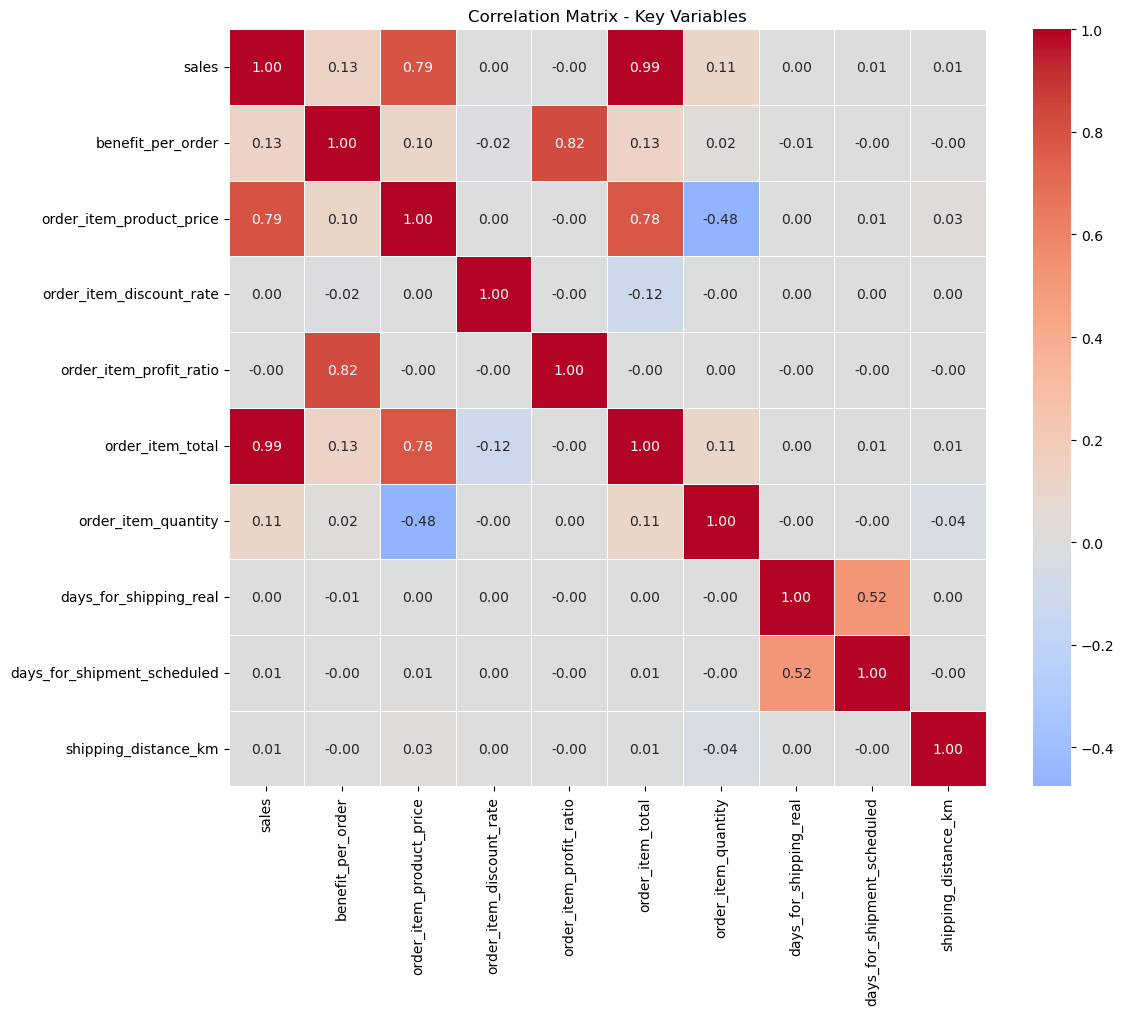

In [15]:
# Calculate correlation matrix
corr_matrix = df[continuous_vars].corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Matrix - Key Variables')
plt.tight_layout()
plt.show()

The coefficients represent correlation strength. +1 is a strong positive correlation between variables, 0 is no correlation, and -1 is a strong negative correlation. 

#### There are a couple examples of each here:
1. order_item_product_price and sales have a positive correlation. This makes sense - a higher item price drives sales upward. A near identical relationship exists with order_item_product_price and order_item_total. 
2. days_for_shipment_scheduled and days_for_shipment_real are positively correlated, but not perhaps as strong as you'd like to see. This suggests that the estimated shipping times aren't as accurate as one would hope.
3. order_item_quantity and order_item_product_price have a notable negative relationship. This means that higher priced products are ordered in smaller quanities.

Perhaps one of most interesting results here is that shipping_distance_km isn't correlated with anything! How does distance not affect shipping days? Worth exploring more...

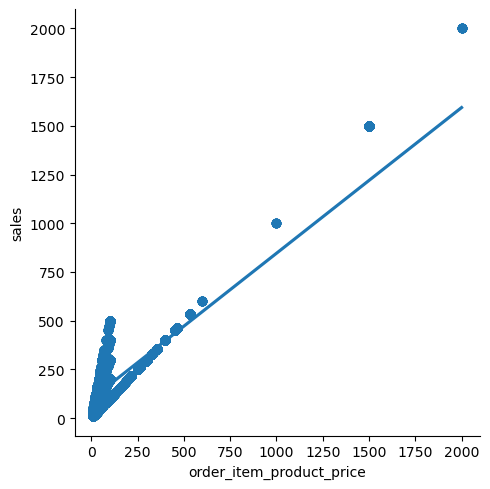

In [16]:
# Create scatterplot for a few interesting correlated relationships

sns.lmplot(x = 'order_item_product_price', y = 'sales', data = df)

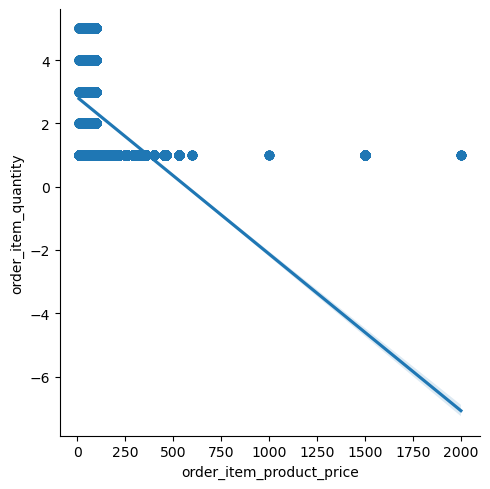

In [17]:
sns.lmplot(x = 'order_item_product_price', y = 'order_item_quantity', data = df)

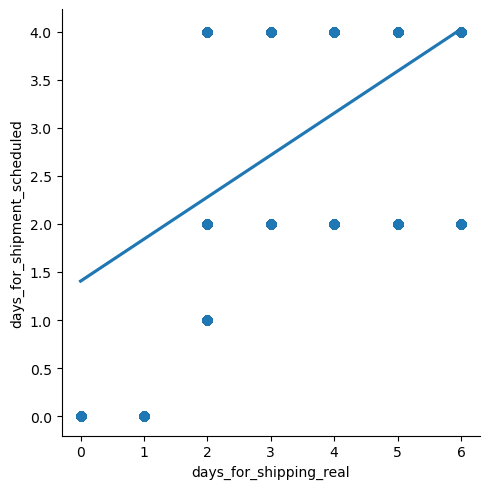

In [18]:
sns.lmplot(x = 'days_for_shipping_real', y = 'days_for_shipment_scheduled', data = df)

1st plot: shows a strong linear relationship with a lot of concentration in the lower left (low priced items, lower sales). But there are some high-value outliers.

2nd plot: shows a negative relationship. Because order_item_quantity is discrete, the y axis has horizontal bands. Quantity decreases down to 1 for products over \$250. This also relates to the 1st plot that the lower priced items are purchased most. This seems typical/expected behavior. People order less high priced items and more low priced items. 

3rd plot: this is more scattered overall. Scheduling ranges from 0-4 days while the actual times range from 0-6. For deliveries scheduled for 2 days or 4 days, the actual range is 2-6. It also looks like 3 day shipping isn't an option, too. Ultimately the delivery scheduling system is unreliable and could be improved. 

In [19]:
# Check what scheduled days exist
print("Scheduled shipping days available:")
print(df['days_for_shipment_scheduled'].value_counts().sort_index())

# Compare to shipping modes
print("\nShipping mode distribution:")
print(df['shipping_mode'].value_counts())

# See if they align
print("\nScheduled days by shipping mode:")
print(df.groupby('shipping_mode')['days_for_shipment_scheduled'].value_counts().sort_index())

Scheduled shipping days available:
days_for_shipment_scheduled
0      9737
1     27814
2     35216
4    107752
Name: count, dtype: int64

Shipping mode distribution:
shipping_mode
Standard Class    107752
Second Class       35216
First Class        27814
Same Day            9737
Name: count, dtype: int64

Scheduled days by shipping mode:
shipping_mode   days_for_shipment_scheduled
First Class     1                               27814
Same Day        0                                9737
Second Class    2                               35216
Standard Class  4                              107752
Name: count, dtype: int64


There's a 1-to-1 mapping between shipping mode and scheduled delivery time. But we can see in plot 3 that these tiered delivery times are poor predictors of actual delivery time. 

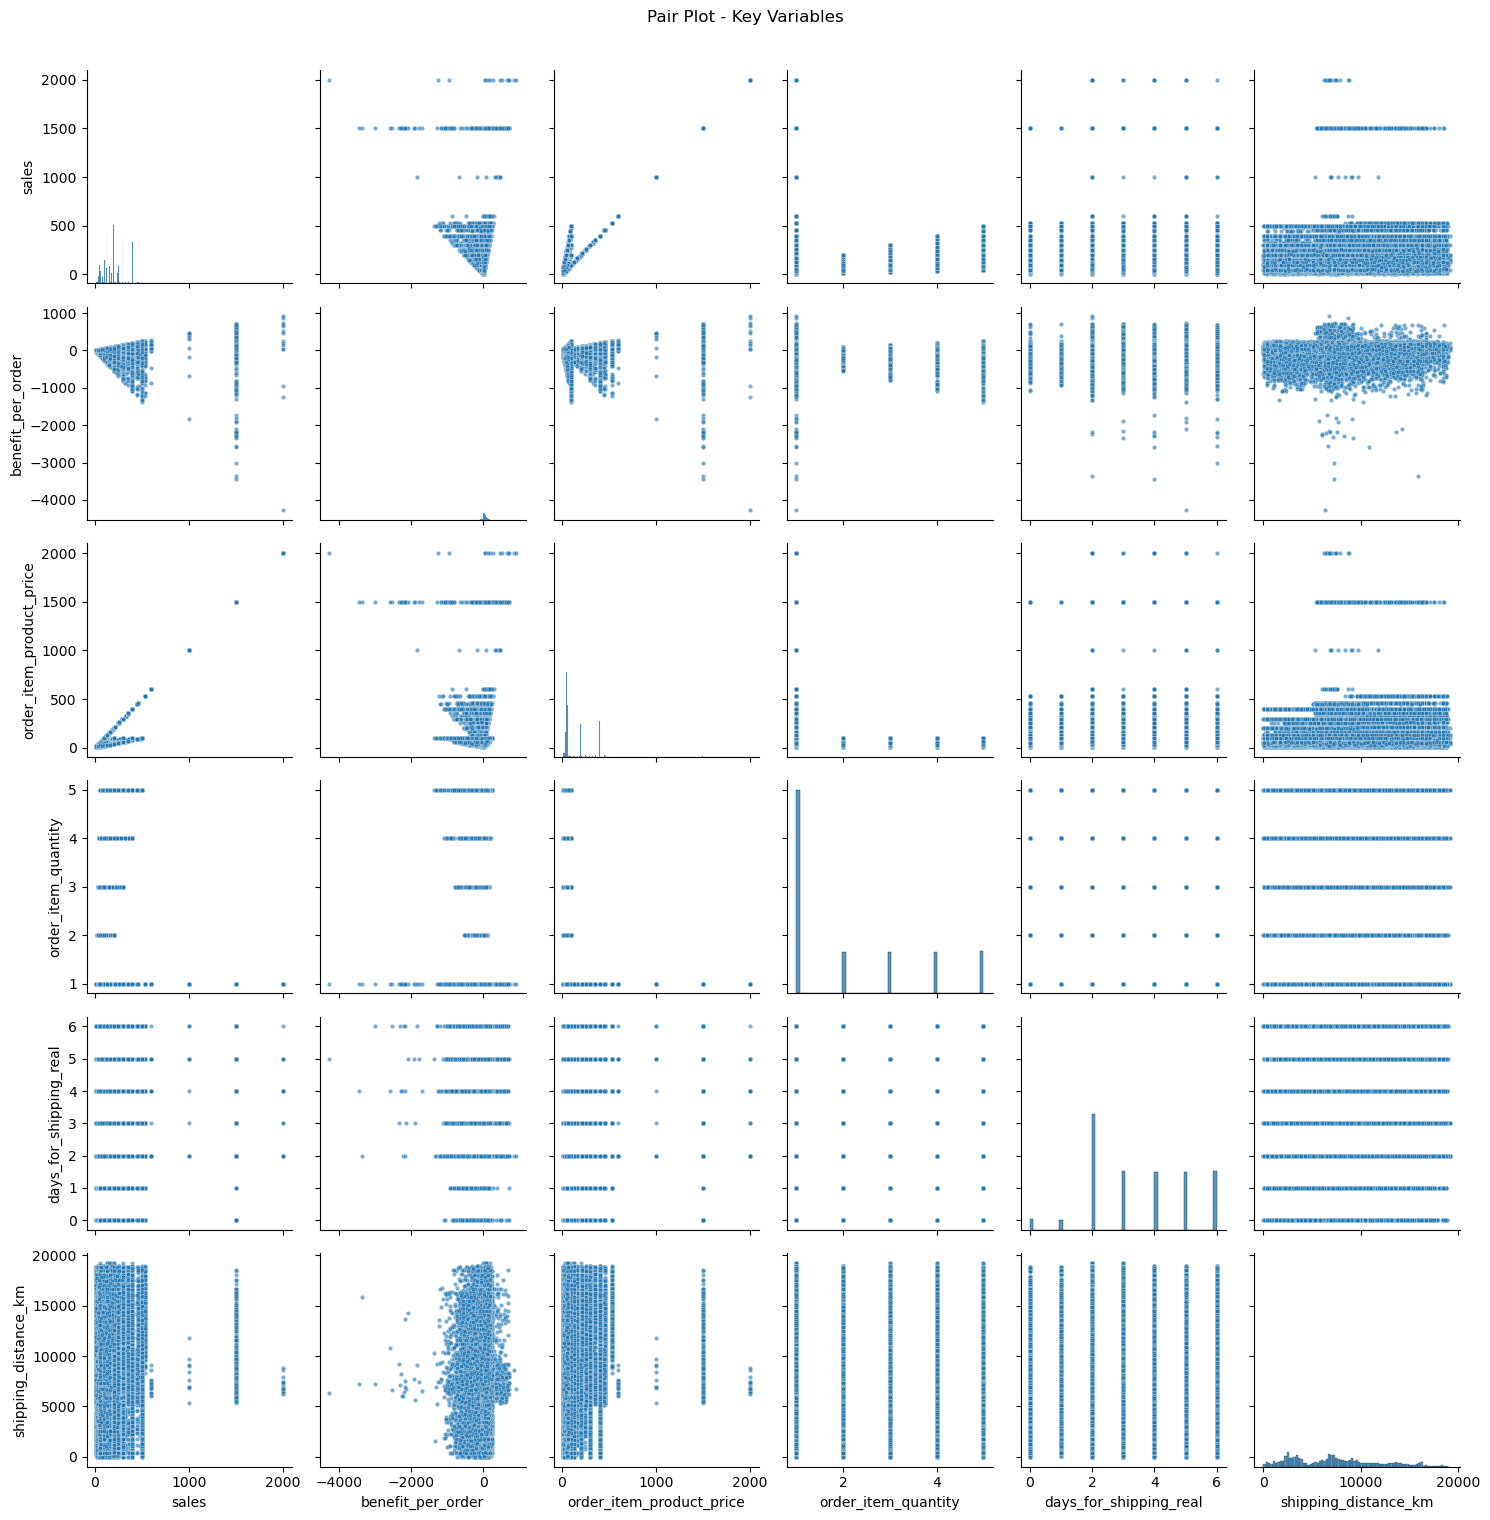

In [20]:
# Select key variables for clearer visualization
key_vars = [
    'sales',
    'benefit_per_order',
    'order_item_product_price',
    'order_item_quantity',
    'days_for_shipping_real',
    'shipping_distance_km'
]

sns.pairplot(df[key_vars], diag_kind='hist', plot_kws={'alpha': 0.6, 's': 10})
plt.suptitle('Pair Plot - Key Variables', y=1.01)
plt.tight_layout()
plt.show()

### Distributions
Most continuous variables (sales, benefit_per_order, and order_item_product price) are right-skewed. The discrete variables show clear banding. 
### Relationships
The strongest linear relationships are between sales and product price, confirming the correlation matrix findings. Shipping distance shows little to no relationship with other variables, suggesting distance alone is not a primary driver of sales, profit, or delivery performance.
### Further expoloration
The negative profit outliers visible in benefit_per_order plots will need some further digging. 

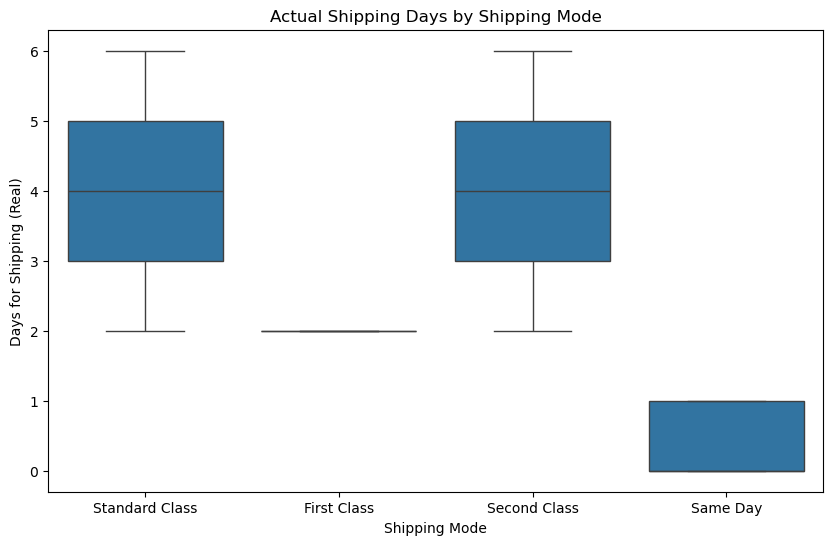

In [21]:
# Delivery Performance by Shipping Mode

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='shipping_mode', y='days_for_shipping_real')
plt.title('Actual Shipping Days by Shipping Mode')
plt.xlabel('Shipping Mode')
plt.ylabel('Days for Shipping (Real)')
plt.show()

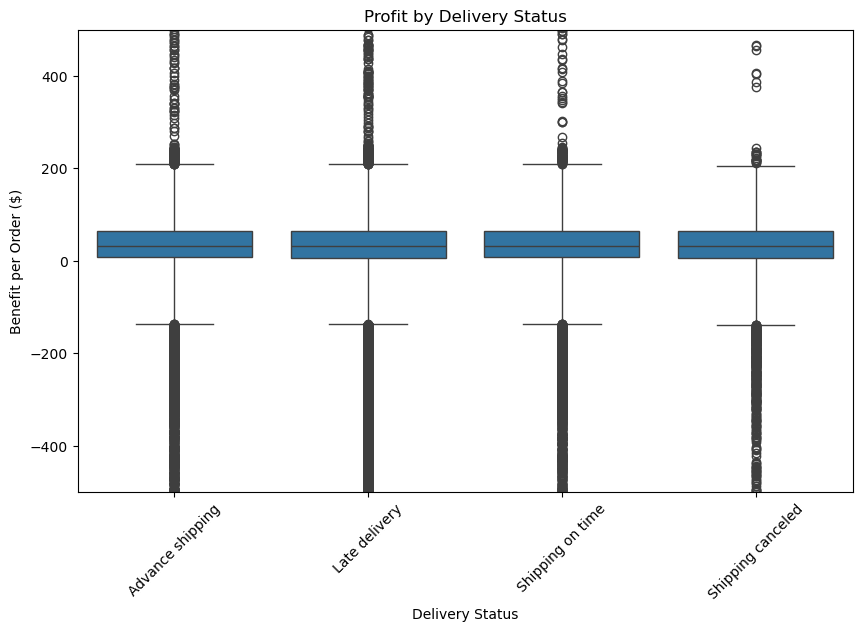

In [22]:
# Profitability by Delivery Status

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='delivery_status', y='benefit_per_order', whis=2.5)
plt.title('Profit by Delivery Status')
plt.xlabel('Delivery Status')
plt.ylabel('Benefit per Order (\$)')
plt.ylim(-500, 500)
plt.xticks(rotation=45)
plt.show()

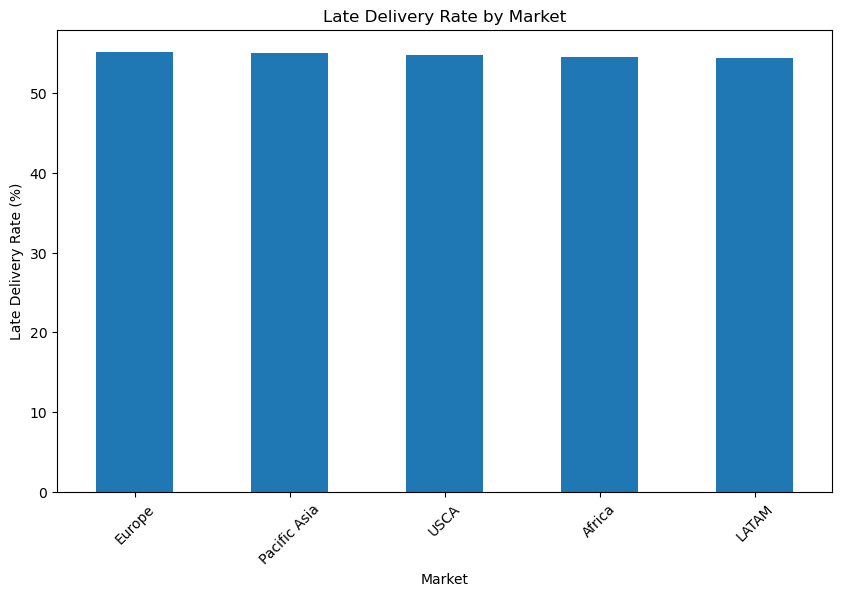

In [23]:
# Late Delivery Rate by Market

plt.figure(figsize=(10, 6))
late_by_market = df.groupby('market')['late_delivery_risk'].mean() * 100
late_by_market.sort_values(ascending=False).plot(kind='bar')
plt.title('Late Delivery Rate by Market')
plt.xlabel('Market')
plt.ylabel('Late Delivery Rate (%)')
plt.xticks(rotation=45)
plt.show()

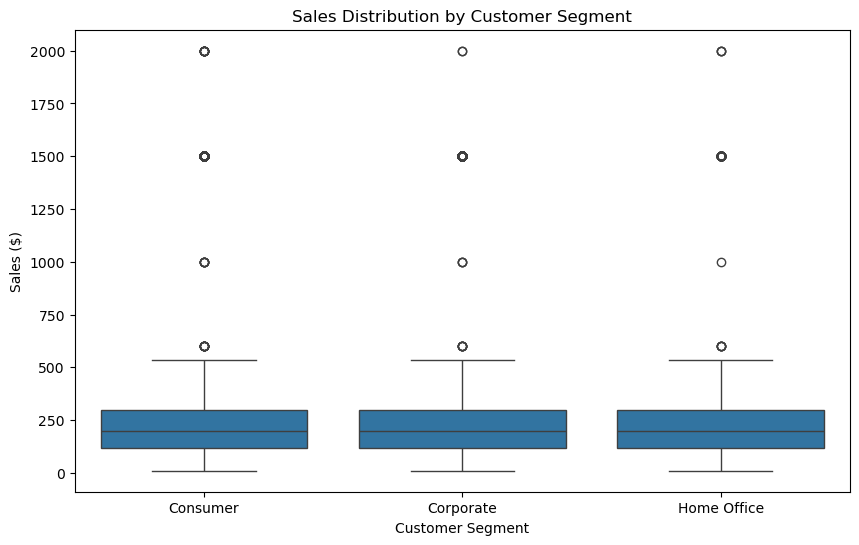

In [24]:
# Sales by Customer Segment

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='customer_segment', y='sales', order=['Consumer', 'Corporate', 'Home Office'])
plt.title('Sales Distribution by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Sales (\$)')
plt.show()

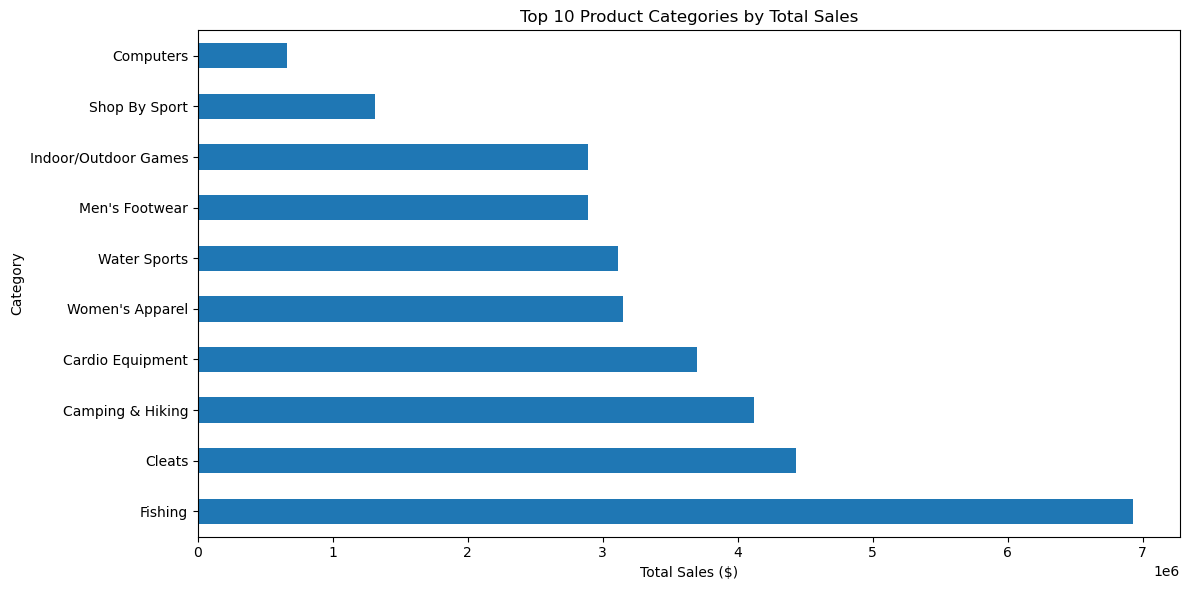

In [25]:
# Top 10 categories by Sales

top_categories = df.groupby('category_name')['sales'].sum().nlargest(10)

plt.figure(figsize=(12, 6))
top_categories.plot(kind='barh')
plt.title('Top 10 Product Categories by Total Sales')
plt.xlabel('Total Sales (\$)')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

In [26]:
# See which categories belong to each department
dept_categories = df.groupby('department_name')['category_name'].unique()

for dept in sorted(dept_categories.index):
    print(f"\n{dept.upper()}:")
    print(f"  Categories: {list(dept_categories[dept])}")
    print(f"  Total categories: {len(dept_categories[dept])}")


APPAREL:
  Categories: ['Cleats', "Men's Footwear", "Women's Clothing", 'Crafts', "Men's Clothing", "Children's Clothing", 'Baby ']
  Total categories: 7

BOOK SHOP:
  Categories: ['Books ']
  Total categories: 1

DISCS SHOP:
  Categories: ['DVDs', 'CDs ', 'Music', 'Video Games']
  Total categories: 4

FAN SHOP:
  Categories: ['Hunting & Shooting', 'Camping & Hiking', 'Fishing', 'Toys', 'Water Sports', 'Indoor/Outdoor Games']
  Total categories: 6

FITNESS:
  Categories: ['Sporting Goods', 'Baseball & Softball', 'Basketball', 'Soccer', 'Tennis & Racquet', 'Lacrosse', 'Hockey']
  Total categories: 7

FOOTWEAR:
  Categories: ['Electronics', 'Boxing & MMA', 'Cardio Equipment', 'Fitness Accessories', 'As Seen on  TV!', 'Strength Training']
  Total categories: 6

GOLF:
  Categories: ['Shop By Sport', "Women's Apparel", "Girls' Apparel"]
  Total categories: 3

HEALTH AND BEAUTY :
  Categories: ['Health and Beauty']
  Total categories: 1

OUTDOORS:
  Categories: ['Trade-In', 'Electronics', "

# Data Quality Issue Found
The categories are mismatched with the departments

In [27]:
# Create logical department groupings based on category names
category_to_dept = {
    # Footwear
    'Cleats': 'Footwear',
    "Men's Footwear": 'Footwear',
    'Golf Shoes': 'Footwear',
    
    # Apparel
    "Women's Apparel": 'Apparel',
    "Girls' Apparel": 'Apparel',
    "Men's Clothing": 'Apparel',
    "Women's Clothing": 'Apparel',
    "Children's Clothing": 'Apparel',
    'Baby': 'Apparel',
    'Golf Apparel': 'Apparel',
    
    # Technology & Electronics
    'Electronics': 'Technology',
    'Consumer Electronics': 'Technology',
    'Cameras': 'Technology',
    'Computers': 'Technology',
    
    # Fitness & Sports Equipment
    'Cardio Equipment': 'Fitness Equipment',
    'Strength Training': 'Fitness Equipment',
    'Fitness Accessories': 'Fitness Equipment',
    'Boxing & MMA': 'Fitness Equipment',
    
    # Team Sports
    'Baseball & Softball': 'Team Sports',
    'Basketball': 'Team Sports',
    'Soccer': 'Team Sports',
    'Tennis & Racquet': 'Team Sports',
    'Lacrosse': 'Team Sports',
    'Hockey': 'Team Sports',
    'Sporting Goods': 'Team Sports',
    
    # Golf
    'Shop By Sport': 'Golf',
    'Golf Balls': 'Golf',
    'Golf Gloves': 'Golf',
    "Kids' Golf Clubs": 'Golf',
    "Women's Golf Clubs": 'Golf',
    "Men's Golf Clubs": 'Golf',
    'Golf Bags & Carts': 'Golf',
    
    # Outdoor Recreation
    'Camping & Hiking': 'Outdoor Recreation',
    'Fishing': 'Outdoor Recreation',
    'Hunting & Shooting': 'Outdoor Recreation',
    'Water Sports': 'Outdoor Recreation',
    
    # Entertainment
    'Indoor/Outdoor Games': 'Entertainment',
    'Toys': 'Entertainment',
    'Video Games': 'Entertainment',
    'DVDs': 'Entertainment',
    'CDs': 'Entertainment',
    'Music': 'Entertainment',
    'Books': 'Entertainment',
    
    # Other
    'Health and Beauty': 'Health & Beauty',
    'Pet Supplies': 'Pet Supplies',
    'Garden': 'Home & Garden',
    'Accessories': 'Accessories',
    'Crafts': 'Crafts & Hobbies',
    'Trade-In': 'Trade-In',
    'As Seen on  TV!': 'As Seen on TV'
}
df['category_name'] = df['category_name'].str.strip()

# Apply the mapping
df['department_corrected'] = df['category_name'].map(category_to_dept)

# Check if any categories weren't mapped
unmapped = df[df['department_corrected'].isnull()]['category_name'].unique()
if len(unmapped) > 0:
    print(f"Unmapped categories: {unmapped}")
else:
    print("✓ All categories mapped!")

# Verify the new groupings
print("\nNew Department Distribution:")
print(df['department_corrected'].value_counts())

✓ All categories mapped!

New Department Distribution:
department_corrected
Footwear              47321
Outdoor Recreation    47034
Apparel               24394
Entertainment         22258
Golf                  14438
Fitness Equipment     13330
Technology             4621
Team Sports            2479
Accessories            1780
Trade-In                974
Pet Supplies            492
Crafts & Hobbies        484
Home & Garden           484
Health & Beauty         362
As Seen on TV            68
Name: count, dtype: int64


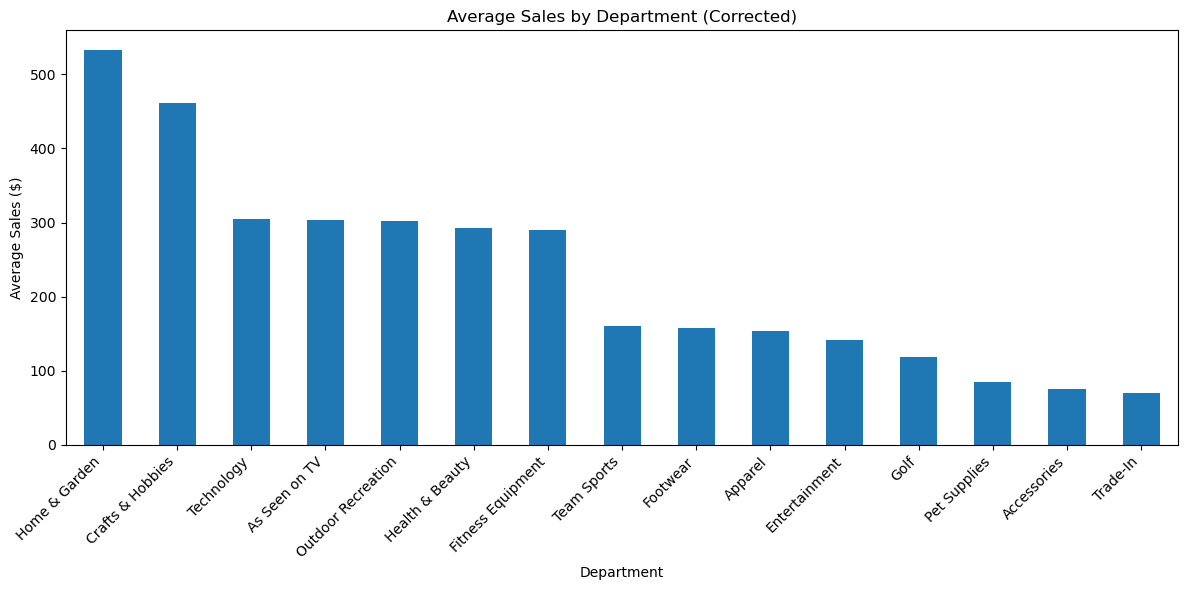

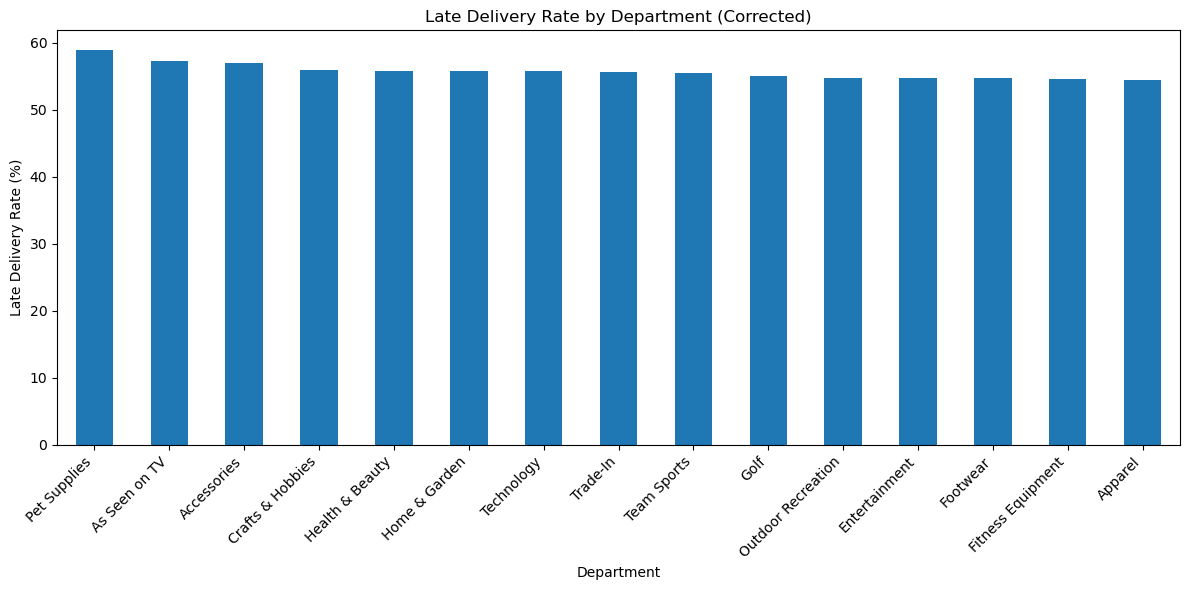

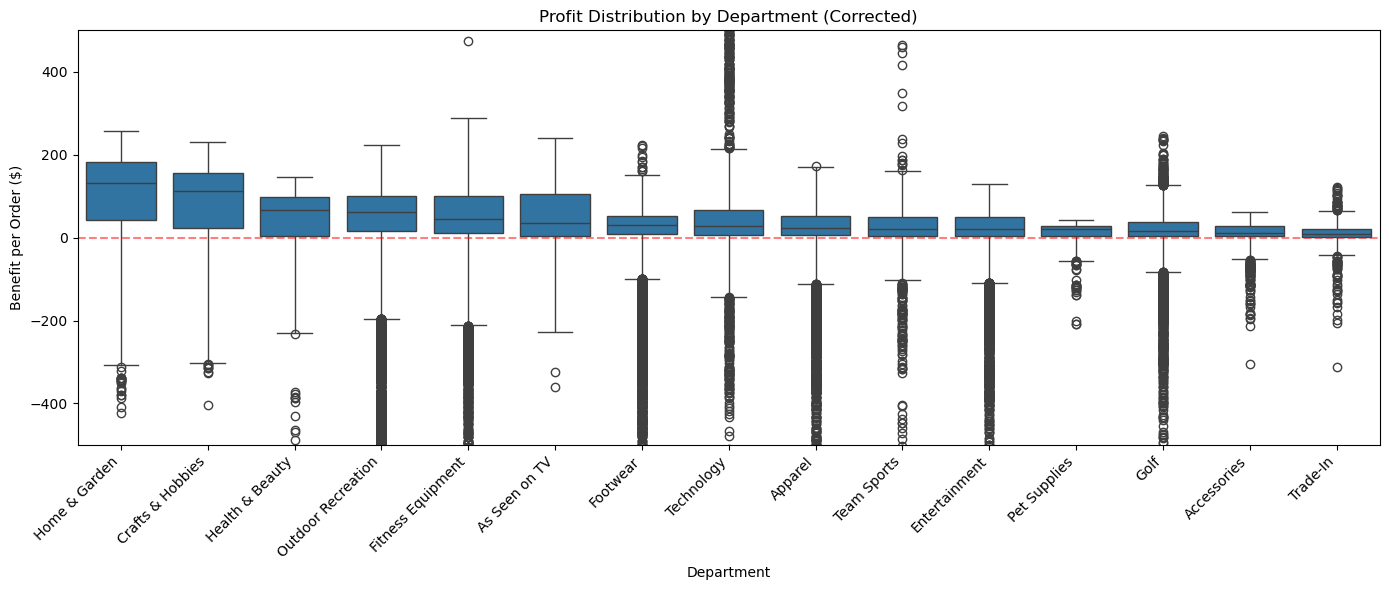

In [28]:
# 1. Average Sales by Department (Corrected)
plt.figure(figsize=(12, 6))
dept_sales = df.groupby('department_corrected')['sales'].mean().sort_values(ascending=False)
dept_sales.plot(kind='bar')
plt.title('Average Sales by Department (Corrected)')
plt.xlabel('Department')
plt.ylabel('Average Sales (\$)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Late Delivery Rate by Department (Corrected)
plt.figure(figsize=(12, 6))
late_by_dept = df.groupby('department_corrected')['late_delivery_risk'].mean() * 100
late_by_dept.sort_values(ascending=False).plot(kind='bar')
plt.title('Late Delivery Rate by Department (Corrected)')
plt.xlabel('Department')
plt.ylabel('Late Delivery Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Profit Distribution by Department (Corrected)
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='department_corrected', y='benefit_per_order', whis=2.5,
            order=df.groupby('department_corrected')['benefit_per_order'].median().sort_values(ascending=False).index)
plt.title('Profit Distribution by Department (Corrected)')
plt.xlabel('Department')
plt.ylabel('Benefit per Order (\$)')
plt.ylim(-500, 500)
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Further exploration on the overall analysis
### I want to understand how order_status plays into these figures

In [29]:
# Check order_status distribution
print("ORDER STATUS:")
print(df['order_status'].value_counts())
print(f"\nPercentages:")
print(df['order_status'].value_counts(normalize=True) * 100)

# Check type distribution
print("\n" + "="*60)
print("TYPE:")
print(df['type'].value_counts())
print(f"\nPercentages:")
print(df['type'].value_counts(normalize=True) * 100)

# Cross-tab: type by order_status
print("\n" + "="*60)
print("TYPE × ORDER STATUS:")
print(pd.crosstab(df['type'], df['order_status'], margins=True))

ORDER STATUS:
order_status
COMPLETE           59491
PENDING_PAYMENT    39832
PROCESSING         21902
PENDING            20227
CLOSED             19616
ON_HOLD             9804
SUSPECTED_FRAUD     4062
CANCELED            3692
PAYMENT_REVIEW      1893
Name: count, dtype: int64

Percentages:
order_status
COMPLETE           32.955534
PENDING_PAYMENT    22.065267
PROCESSING         12.132795
PENDING            11.204915
CLOSED             10.866446
ON_HOLD             5.431007
SUSPECTED_FRAUD     2.250179
CANCELED            2.045214
PAYMENT_REVIEW      1.048643
Name: proportion, dtype: float64

TYPE:
type
DEBIT       69295
TRANSFER    49883
PAYMENT     41725
CASH        19616
Name: count, dtype: int64

Percentages:
type
DEBIT       38.386541
TRANSFER    27.633102
PAYMENT     23.113910
CASH        10.866446
Name: proportion, dtype: float64

TYPE × ORDER STATUS:
order_status  CANCELED  CLOSED  COMPLETE  ON_HOLD  PAYMENT_REVIEW  PENDING  \
type                                               

In [30]:
# Do incomplete orders have different sales/profit patterns?
print("\nSALES BY ORDER STATUS:")
print(df.groupby('order_status')['sales'].describe())

print("\nPROFIT BY ORDER STATUS:")
print(df.groupby('order_status')['benefit_per_order'].describe())

# Are negative profits concentrated in certain statuses?
print("\nNEGATIVE PROFIT RATE BY ORDER STATUS:")
negative_by_status = df.groupby('order_status').apply(
    lambda x: (x['benefit_per_order'] < 0).sum() / len(x) * 100
)
print(negative_by_status.sort_values(ascending=False))


SALES BY ORDER STATUS:
                   count        mean         std    min         25%  \
order_status                                                          
CANCELED          3692.0  201.617119  126.402898  11.29  119.980003   
CLOSED           19616.0  205.068524  134.193693   9.99  119.980003   
COMPLETE         59491.0  203.313357  134.212370   9.99  119.980003   
ON_HOLD           9804.0  202.115739  131.587266   9.99  119.980003   
PAYMENT_REVIEW    1893.0  202.669655  131.822974   9.99  119.980003   
PENDING          20227.0  203.714484  127.671030   9.99  119.980003   
PENDING_PAYMENT  39832.0  203.522232  129.852731   9.99  119.980003   
PROCESSING       21902.0  205.646231  135.022487   9.99  119.980003   
SUSPECTED_FRAUD   4062.0  203.332092  132.421653  11.29  119.980003   

                        50%         75%         max  
order_status                                         
CANCELED         199.919998  299.950012  1500.00000  
CLOSED           199.919998  299

/var/folders/58/c77n0yc97t9c_v_2y266x2s40000gn/T/ipykernel_50924/1911317305.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  negative_by_status = df.groupby('order_status').apply(


### Takeaway on order_status

The order_status field must represent processing workflow stages rather than the actual financial outcomes. All statuses (COMPLETE, PENDING, CANCELED, SUSPECTED_FRAUD, etc.) show nearly identical sales and profit distributions, suggesting that financial metrics are recorded at order placement rather than final settlement. This means the analysis reflects initial transaction values and may not account for subsequent refunds, adjustments, or reversals. For portfolio purposes, all orders are included in the analysis with the understanding that this represents a snapshot of order-time financials.

# Further digging into the negative profits

In [31]:
# Check correlation of discounts with negative profits

print("Do high discounts correlate with negative profit?")
negative_profit = df[df['benefit_per_order'] < 0]
positive_profit = df[df['benefit_per_order'] >= 0]

print(f"\nNegative profit orders - Avg discount rate: {negative_profit['order_item_discount_rate'].mean():.2%}")
print(f"Positive profit orders - Avg discount rate: {positive_profit['order_item_discount_rate'].mean():.2%}")

# Check extreme cases
print("\nWorst losses (< -\$1000):")
print(df[df['benefit_per_order'] < -1000][['sales', 'benefit_per_order', 'order_item_discount_rate', 'order_item_product_price', 'order_item_quantity', 'department_corrected']].head(10))

Do high discounts correlate with negative profit?

Negative profit orders - Avg discount rate: 10.22%
Positive profit orders - Avg discount rate: 10.15%

Worst losses (< -\$1000):
             sales  benefit_per_order  order_item_discount_rate  \
4311    532.580017       -1140.790039                      0.16   
8259   1500.000000       -3366.000000                      0.12   
9126    499.950012       -1374.859985                      0.00   
9140    499.950012       -1232.130005                      0.07   
9333    499.950012       -1114.640015                      0.09   
9382    499.950012       -1336.369995                      0.01   
10203   399.959992       -1044.900024                      0.05   
11814  1500.000000       -2152.500000                      0.18   
11909  1500.000000       -2328.000000                      0.03   
12042   399.959992       -1066.890015                      0.03   

       order_item_product_price  order_item_quantity department_corrected  
4311  

In [32]:
print("NEGATIVE PROFIT ORDER CHARACTERISTICS:")
print("="*60)

neg_by_dept = df.groupby('department_corrected')['benefit_per_order'].apply(
    lambda x: (x < 0).sum() / len(x) * 100
).sort_values(ascending=False)
print("\nNegative profit rate by department:")
print(neg_by_dept)

# Also check average profit by department
print("\n\nAverage profit by department:")
avg_profit = df.groupby('department_corrected')['benefit_per_order'].mean().sort_values(ascending=False)
print(avg_profit)

NEGATIVE PROFIT ORDER CHARACTERISTICS:

Negative profit rate by department:
department_corrected
Health & Beauty       23.480663
Pet Supplies          21.138211
As Seen on TV         20.588235
Crafts & Hobbies      19.834711
Golf                  19.074664
Entertainment         18.761794
Footwear              18.744321
Outdoor Recreation    18.726878
Apparel               18.689022
Fitness Equipment     18.604651
Trade-In              18.172485
Accessories           17.921348
Technology            17.788357
Team Sports           17.668415
Home & Garden         16.942149
Name: benefit_per_order, dtype: float64


Average profit by department:
department_corrected
Home & Garden         69.097128
Crafts & Hobbies      52.750351
Technology            33.339405
Outdoor Recreation    32.206559
Fitness Equipment     29.800688
Health & Beauty       26.225497
Team Sports           18.772917
Footwear              17.306181
Apparel               17.259077
Entertainment         15.474358
Golf      

### Takeaway on negative profits

The data reveals that approximately 18-19% of orders show negative profitability, consistent across most product departments. While this may seem counterintuitive, several business explanations are possible:

**Customer acquisition strategy** - accepting short-term losses for long-term customer lifetime value

**Full cost accounting** - profit calculations may include shipping, overhead, returns, and customer service costs that exceed revenue on some orders

**Strategic loss leaders** - certain products priced below cost to drive traffic and cross-selling

The negative profit orders are distributed evenly across delivery statuses, customer segments, and geographic regions, suggesting these are not operational failures but potentially intentional business decisions or systemic cost structures. Further analysis of customer lifetime value and repeat purchase behavior would be needed to fully assess profitability.

# Insights on categorical visualizations

I ended up running quite of a few of these, but there were some interesting things:
### Shipping related observations
1. Standard Class and Second Class shipping show nearly identical actual delivery times despite different promised schedules (4 days vs 2 days). First Class has no variance - consistently 2 days. Estimated delivery times aren't good predictors of actual delivery times. 
2. All Markets and Departments have nearly identical late deliveries (~55%). Geography nor Product Type explain late deliveries. 
3. Delivery status doesn't seem to affect profitability. All 4 statuses have some serious negative profit outliers.
### Sales and Profit observations
1. Customer segments look pretty much identical in sales distribution. B2B customers aren't spending any differently from B2C.
2. Home & Garden (＄535 avg) and Crafts & Hobbies (＄463 avg) lead in average sales and show positive median profitability. Health & Beauty, Outdoor Recreation, and Fitness Equipment also demonstrate consistent profitability.
3. All departments have negative profit outliers. One particularly disastrous loss of over ＄4k in fitness equipment.
4. Among individual categories, Fishing (＄7M), Cleats (＄5M), and Camping & Hiking (＄4M) lead in total sales.

# Revisiting original business questions

1. What predicts a late delivery?
2. Which orders result in negative profits?
3. What patterns or trends exist across regions?
4. Which categories sell best in each market?
5. How do sales and profitability vary by customer segment?
6. Which products are most/least profitable?
7. Can we identify distinct customer segments based on purchasing behavior?
8. Do late deliveries affect profitability?
9. How has order volume and delivery performance changed over time?
10. What factors are associated with different order statuses?

## Questions I can answer (at least partially) at this point:

**What patterns or trends exist across regions?** Late deliveries are extremely consistent across every market. This also somewhat answers my first questions "What predicts a late delivery?" - the answer, NOT geographical location. Additionally, shipping distance shows no correlation with delivery performance. 

**How do sales and profitability vary by customer segment?** They essentially don't. A further look is required here, but from this initial overview, customers are acting consistent across segments. That's a bit surprising given assumptions on business spending vs consumer spending.
**Do late deliveries affect profitability?** No. Profit looks the same across each deliveryn status. 

**Which orders result in negative profits?** Approximately 18-19% of all orders show negative profit, distributed relatively evenly across delivery statuses, customer segments, markets, and departments (range: 17-24%). Analysis reveals several patterns in unprofitable orders:

High-quantity orders of moderate-priced items show the worst losses, particularly in Fitness Equipment where orders of 4-5 units at ~＄100 each result in losses of ＄1,000-＄1,400, suggesting product costs significantly exceed selling prices.

High-value single items in Technology (selling at ＄1,500) show losses of ＄2,000-＄3,500 per order, indicating further need for more analysis or additional data.

Discount rates do NOT correlate with negative profits (10.22% avg discount for unprofitable orders vs 10.15% for profitable orders), suggesting pricing structure rather than promotional activity drives losses.

The consistency of the ~18-19% negative profit rate across nearly all categories suggests this may be an intentional business model (customer acquisition strategy, fully-loaded cost accounting including returns/shipping) or a characteristic of this simulated dataset.

**Which products are most/least profitable?** 

Home & Garden and Crafts & Hobbies show the highest average sales (535 and 463 respectively) and positive median profitability. Technology and Fitness Equipment have high sales but extreme negative outliers. Entertainment, Trade-In, and Pet Supplies show lowest average sales (~70-140) with near-zero median profit.

#### Further context on which products are most/least profitable after some more digging:

**Home & Garden:** Highest average profit (＄69.10), highest average sales (＄535), and lowest negative profit rate (16.9%) - the clear winner  
**Crafts & Hobbies:** High average profit (＄52.75), high average sales (＄463), though elevated negative profit rate (19.8%) indicates volatility  
**Outdoor Recreation:** Solid profit (＄32.21), massive volume (47k orders), moderate risk (18.7% negative rate)

**Moderate Performance:**

**Technology:** Despite extreme outliers (losses up to -＄3,500), maintains decent average profit (＄33.34) with relatively low negative profit rate (17.8%)  
**Fitness Equipment:** Shows catastrophic outliers (-＄4,300), but average profit is respectable (＄29.80) with 18.6% negative rate

**Least Profitable:**

**Pet Supplies:** High risk (21.1% negative rate) with minimal reward (avg profit ＄7.30) - worst risk/reward profile  
**Health & Beauty:** Highest negative profit rate (23.5%) despite moderate average profit (＄26.23)  
**Entertainment, Trade-In, Accessories:** Low average sales (＄70-140), near-zero average profit (＄8-15)

### New Questions (futher exploration)
  
11. Why does First Class have zero variance while other shipping modes vary by multiple days sometimes?  
12. What is causing the systemic 55% late delivery rate if it's not geography, product type, shipping mode, or customer segment?


# Hypotheses

### Hypothesis 1: Predicting Late Deliveries
H0: Shipping mode, order value, product department, order quantity, and shipping distance do not predict late delivery risk.

H1: At least one of these factors significantly predicts late delivery probability.

Analysis: Logistic regression with late_delivery_risk as target variable.

### Hypothesis 2: Predicting Profitability
H0: Product department, order quantity, product price, and shipping mode do not predict order profitability.

H1: Product department and order characteristics significantly predict benefit per order.

Analysis: Linear regression with benefit_per_order as target variable.

### Hypothesis 3: Customer Behavioral Segmentation
H0: Customer orders do not form distinct behavioral clusters beyond traditional segment labels (Consumer/Corporate/Home Office).

H1: Customers can be grouped into meaningful behavioral segments based on order value, frequency, product preferences, and profitability patterns.

Analysis: K-means clustering on customer order characteristics.

### Hypothesis 4: Temporal Patterns
H0: Order volume shows no seasonal pattern or trend over time.

H1: Order volume exhibits significant seasonality, trends, and/or patterns that can be forecasted.

Analysis: Time-series decomposition and forecasting.

### Hypothesis 5: Geographic Performance
H0: Revenue, profitability, and delivery performance do not vary significantly by geographic region.

H1: Geographic markets show distinct patterns in sales, profit margins, and operational performance.

Analysis: Geospatial choropleth mapping and regional analysis.

# Export Data

In [33]:
df.to_pickle('/Users/stephenhelvig/Documents/Python Projects/DataCo Analysis/Data/Prepared Data/dataco_cleaned_2.pkl')

In [34]:
# df.to_csv('/Users/stephenhelvig/Documents/Python Projects/DataCo Analysis/Data/Prepared Data/dataco_cleaned_2.csv')